In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import timeseries_dataset_from_array
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dropout
import numpy as np
import xarray as xr
import pandas as pd
import os

2025-07-08 14:47:12.815859: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751996832.827982   55941 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751996832.831543   55941 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-08 14:47:12.845387: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Raw Data

In [15]:
# Load the datasets
ds1 = xr.open_dataset('./cmems_obs-wind_glo_phy_my_l3-metopa-ascat-asc-0.125deg_P1D-i_multi-vars_48.31W-47.44W_26.56S-25.69S_2016-01-01-2021-11-15.nc')
df1 = ds1.to_dataframe()

ds2 = xr.open_dataset('./cmems_obs-wind_glo_phy_my_l3-metopa-ascat-des-0.125deg_P1D-i_multi-vars_48.31W-47.44W_26.56S-25.69S_2016-01-01-2021-11-15.nc')
df2 = ds2.to_dataframe()

# Drop rows with NaN values
df1.dropna(inplace=True)
df1 = df1.query("latitude == -26.1875 and longitude == -47.4375")

df2.dropna(inplace=True)
df2 = df2.query("latitude == -26.1875 and longitude == -47.4375")

df3 = pd.concat([df1,df2]).sort_values(by='time')
df3 = df3[~df3.index.duplicated(keep='first')]
df3.reset_index(inplace=True)
df3.drop("latitude",axis=1,inplace=True)
df3.drop("longitude",axis=1,inplace=True)
df3 = df3.set_index("time")

data = pd.date_range(start='2016-01-01', end='2021-11-15', freq='D')
data = df3.reindex(data)

data.dropna(inplace=True)

plt.rcParams.update({'font.size': 10})

# Parameters
seq_length = 10  # Example sequence length
batch_size = 32

# Split indices
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = len(data) - train_size - val_size

# Split data
train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

# Create datasets
def create_dataset(data, seq_length, batch_size):
    return timeseries_dataset_from_array(
        data=data[:-seq_length],
        targets=data[seq_length:],
        sequence_length=seq_length,
        batch_size=batch_size
    )

train_dataset = create_dataset(train_data, seq_length, batch_size)
val_dataset = create_dataset(val_data, seq_length, batch_size)
test_dataset = create_dataset(test_data, seq_length, batch_size)

print(f'Length of train_data: {len(train_data)}')
print(f'Length of val_data: {len(val_data)}')
print(f'Length of test_data: {len(test_data)}')

Length of train_data: 928
Length of val_data: 265
Length of test_data: 133


In [16]:
keras.utils.set_random_seed(812)
tf.config.experimental.enable_op_determinism()

In [25]:
#Load model
model = keras.models.load_model('./RawData/LSTM-RDD/lstm_rdd_model_1.h5', compile=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


2025-07-08 14:55:30.375229: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Predicted value:
             eastward_wind  northward_wind
2021-11-14      -3.370792       -1.466875
Actual value:
             eastward_wind  northward_wind
2021-11-14          -5.65           -2.97


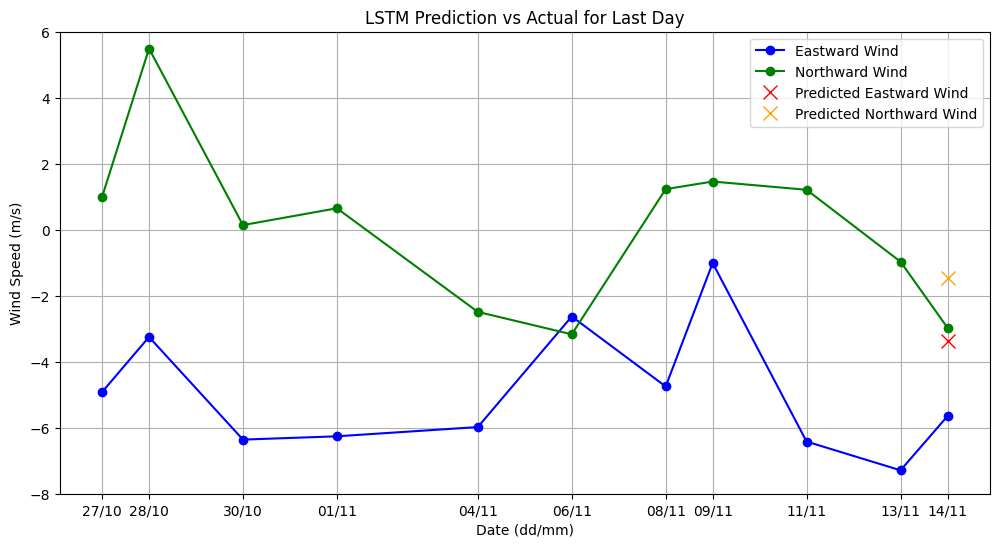

In [26]:
# Get the last 10 days before the last day in the database
last_10_days = data.iloc[-11:-1].values.reshape(1, seq_length, -1)
# Predict the last day
prediction = model.predict(last_10_days)
# Prepare DataFrame for prediction
predicted_date = data.index[-1]
predictions_df = pd.DataFrame(prediction, columns=data.columns, index=[predicted_date])
# Get actual value for the last day
actual_df = data.iloc[[-1]]

# Print prediction and actual value
print("Predicted value:\n", predictions_df)
print("Actual value:\n", actual_df)

# Plot for each variable
plt.figure(figsize=(12, 6))
plt.plot(data.index[-11:], data['eastward_wind'].values[-11:], marker='o', color='blue', label='Eastward Wind')
plt.plot(data.index[-11:], data['northward_wind'].values[-11:], marker='o', color='green', label='Northward Wind')
plt.plot([predicted_date], [predictions_df['eastward_wind'].values[0]], 'x', color='red', label='Predicted Eastward Wind', markersize=10)
plt.plot([predicted_date], [predictions_df['northward_wind'].values[0]], 'x', color='orange', label='Predicted Northward Wind', markersize=10)
plt.title('LSTM Prediction vs Actual for Last Day')
plt.xlabel('Date (dd/mm)')
plt.gca().set_xticks(data.index[-11:])
plt.gca().set_xticklabels([d.strftime('%d/%m') for d in data.index[-11:]])#, rotation=45)
plt.ylabel('Wind Speed (m/s)')
plt.ylim(-8, 6)
plt.legend()
plt.grid()
plt.savefig('./RawData/LSTM-RDD/lstm_rdd_prediction_plot.pdf', dpi=300, bbox_inches='tight')
plt.show()

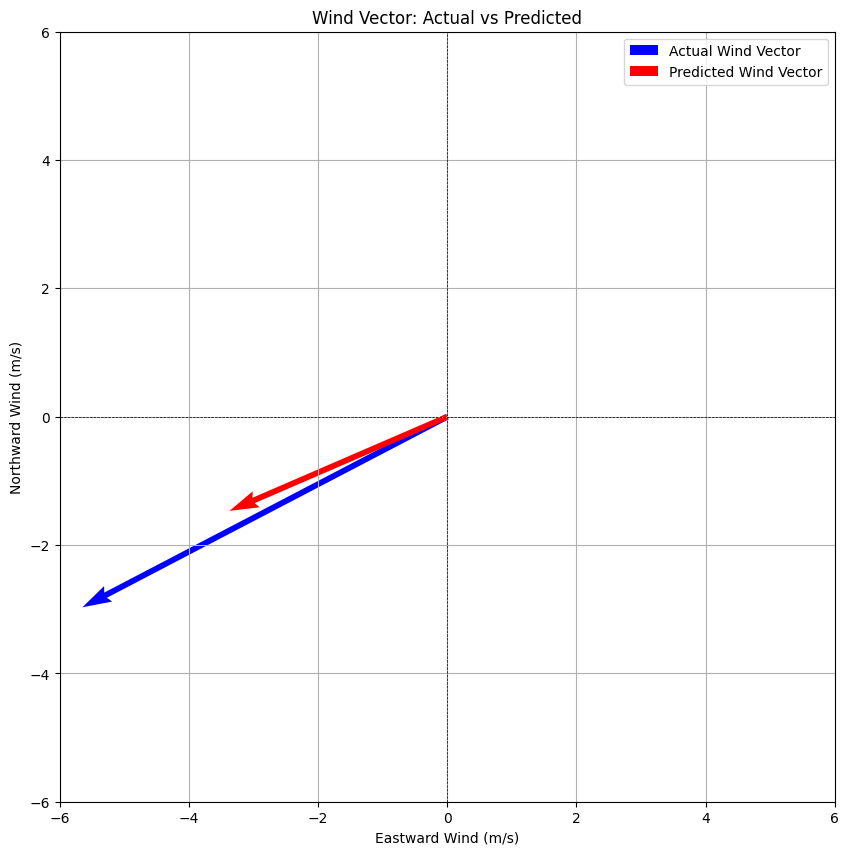

In [27]:
# plot the wind vector for the actual and predicted last day
plt.figure(figsize=(10, 10))
plt.quiver(0, 0, actual_df['eastward_wind'].values[0], actual_df['northward_wind'].values[0], 
           angles='xy', scale_units='xy', scale=1, color='blue', label='Actual Wind Vector')
plt.quiver(0, 0, predictions_df['eastward_wind'].values[0], predictions_df['northward_wind'].values[0], 
           angles='xy', scale_units='xy', scale=1, color='red', label='Predicted Wind Vector')
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel('Eastward Wind (m/s)')
plt.ylabel('Northward Wind (m/s)')
plt.title('Wind Vector: Actual vs Predicted')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.grid()
plt.legend()
plt.show()

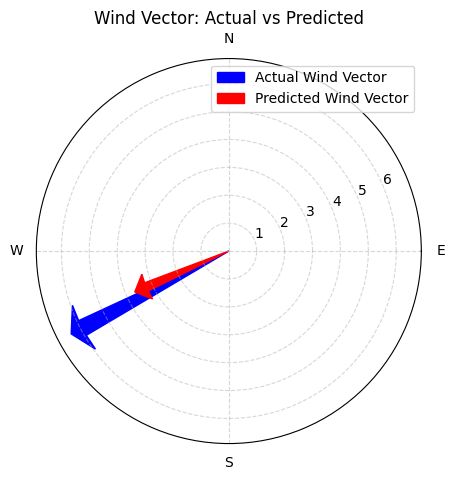

In [28]:
# plot the wind vector for the actual and predicted last day on a polar plot, using arrows
plt.figure(figsize=(5, 5))
ax = plt.subplot(111, polar=True)

# Set custom theta labels for N, E, S, W
ax.set_thetagrids([0, 90, 180, 270], labels=['E', 'N', 'W', 'S'])

# Make inner circles dashed
ax.grid(linestyle='--',alpha=0.5)

actual_angle = np.arctan2(actual_df['northward_wind'].values[0], actual_df['eastward_wind'].values[0])
predicted_angle = np.arctan2(predictions_df['northward_wind'].values[0], predictions_df['eastward_wind'].values[0])
actual_module = np.sqrt(actual_df['eastward_wind'].values[0]**2 + actual_df['northward_wind'].values[0]**2)
predicted_module = np.sqrt(predictions_df['eastward_wind'].values[0]**2 + predictions_df['northward_wind'].values[0]**2)

# Actual wind vector
ax.arrow(actual_angle, 0, 0, actual_module, 
         width=0.1, color='blue', alpha=1, label='Actual Wind Vector', length_includes_head=True)

# Predicted wind vector
ax.arrow(predicted_angle, 0, 0, predicted_module, 
         width=0.1, color='red', alpha=1, label='Predicted Wind Vector', length_includes_head=True)

ax.set_title('Wind Vector: Actual vs Predicted')
ax.set_ylim(0, 6.9)
ax.legend(loc='upper right')
plt.savefig('./RawData/LSTM-RDD/lstm_rdd_prediction_polar_plot.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Proc Data

In [29]:
#Normalize data
df4 = df3.copy()
mean = df4[:int(len(df4) * 0.7)].mean(axis=0)
df4 -= mean
std = df4[:int(len(df4) * 0.7)].std(axis=0)
df4 /= std

print(mean)
print(std)

datap = pd.date_range(start='2016-01-01', end='2021-11-14', freq='D')
datap = df4.reindex(datap)
datap.interpolate(method='ffill', inplace=True)

datap.dropna(inplace=True)

eastward_wind    -2.080216
northward_wind    0.166304
dtype: float64
eastward_wind     3.592385
northward_wind    5.047490
dtype: float64


/tmp/ipykernel_55941/1039711811.py:13: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  datap.interpolate(method='ffill', inplace=True)


In [30]:
datai = pd.date_range(start='2016-01-01', end='2021-11-14', freq='D')
datai = df3.reindex(datai)
datai.interpolate(method='ffill', inplace=True)
print(datai.shape)
datai.dropna(inplace=True)
print(datai.shape)

(2145, 2)
(2145, 2)


/tmp/ipykernel_55941/3063606036.py:3: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  datai.interpolate(method='ffill', inplace=True)


In [31]:
# Load model
modelp = keras.models.load_model('./ProcData/LSTM-RD/lstm_rd_model_7.h5', compile=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2025-07-08 15:02:02.991883: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Predicted value:
             eastward_wind  northward_wind
2021-11-14      -4.829787       -1.875936
Actual value:
             eastward_wind  northward_wind
2021-11-14          -5.65           -2.97


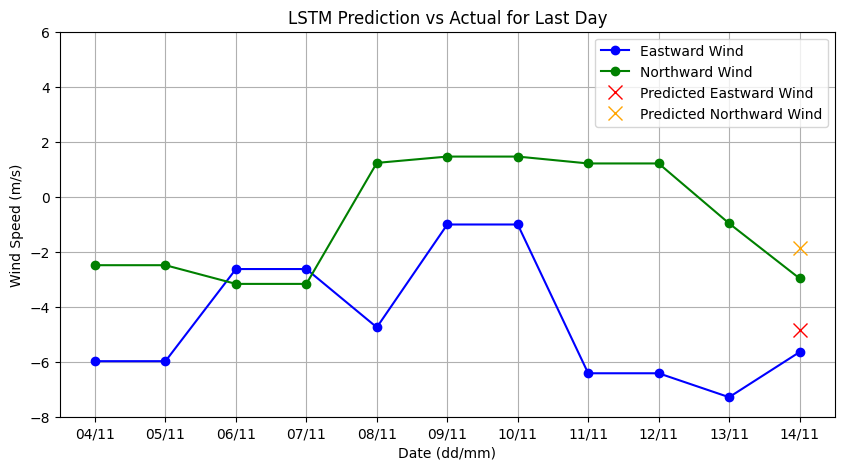

In [34]:
# Get the last 10 days before the last day in the database
last_10_days = datai.iloc[-11:-1].values.reshape(1, seq_length, -1)
last_10_days_norm = datap.iloc[-11:-1].values.reshape(1, seq_length, -1)
# Predict the last day
prediction = modelp.predict(last_10_days_norm)
# Prepare DataFrame for prediction
predicted_date = datap.index[-1]
predictions_df = pd.DataFrame(prediction, columns=data.columns, index=[predicted_date])
#denormalize the predictions
predictions_df = predictions_df * std + mean

# Get actual value for the last day
actual_df = datai.iloc[[-1]]

# Print prediction and actual value
print("Predicted value:\n", predictions_df)
print("Actual value:\n", actual_df)

# Plot for each variable
plt.figure(figsize=(10, 5))
plt.plot(datai.index[-11:], datai['eastward_wind'].values[-11:], marker='o', color='blue', label='Eastward Wind')
plt.plot(datai.index[-11:], datai['northward_wind'].values[-11:], marker='o', color='green', label='Northward Wind')
plt.plot([predicted_date], [predictions_df['eastward_wind'].values[0]], 'x', color='red', label='Predicted Eastward Wind', markersize=10)
plt.plot([predicted_date], [predictions_df['northward_wind'].values[0]], 'x', color='orange', label='Predicted Northward Wind', markersize=10)
plt.title('LSTM Prediction vs Actual for Last Day')
plt.xlabel('Date (dd/mm)')
plt.ylim(-8, 6)
plt.gca().set_xticks(datai.index[-11:])
plt.gca().set_xticklabels([d.strftime('%d/%m') for d in datai.index[-11:]])#, rotation=45)
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid()
plt.savefig('./ProcData/LSTM-RD/lstm_rd_prediction_plot.pdf', dpi=300, bbox_inches='tight')
plt.show()

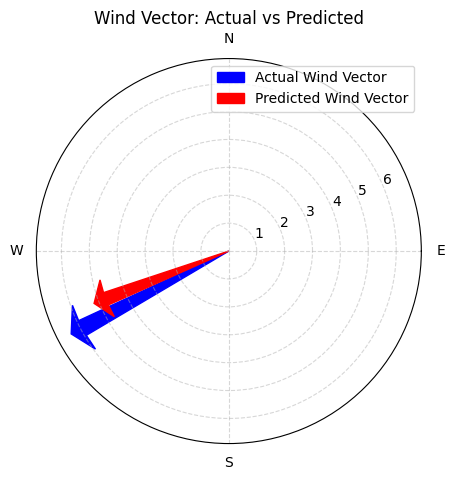

In [33]:
# plot the wind vector for the actual and predicted last day on a polar plot, using arrows
plt.figure(figsize=(5, 5))
ax = plt.subplot(111, polar=True)

# Set custom theta labels for N, E, S, W
ax.set_thetagrids([0, 90, 180, 270], labels=['E', 'N', 'W', 'S'])

# Make inner circles dashed
ax.grid(linestyle='--',alpha=0.5)

actual_angle = np.arctan2(actual_df['northward_wind'].values[0], actual_df['eastward_wind'].values[0])
predicted_angle = np.arctan2(predictions_df['northward_wind'].values[0], predictions_df['eastward_wind'].values[0])
actual_module = np.sqrt(actual_df['eastward_wind'].values[0]**2 + actual_df['northward_wind'].values[0]**2)
predicted_module = np.sqrt(predictions_df['eastward_wind'].values[0]**2 + predictions_df['northward_wind'].values[0]**2)

# Actual wind vector
ax.arrow(actual_angle, 0, 0, actual_module, 
         width=0.1, color='blue', alpha=1, label='Actual Wind Vector', length_includes_head=True)

# Predicted wind vector
ax.arrow(predicted_angle, 0, 0, predicted_module, 
         width=0.1, color='red', alpha=1, label='Predicted Wind Vector', length_includes_head=True)

ax.set_title('Wind Vector: Actual vs Predicted')
ax.set_ylim(0, 6.9)
ax.legend(loc='upper right')
plt.savefig('./ProcData/LSTM-RD/lstm_rd_prediction_polar_plot.pdf', dpi=300, bbox_inches='tight')
plt.show()